# Part 1

The Yale Face Database B consists of single light source images of 10 subjects, each seen in different poses and illumination conditions. In the provided form the database is divided into 5 subsets. In subset 0 the subject is illuminated by an almost frontal light source, while for subsets 1-4 the light source is gradually moved along the horizon. Subset 0 will serve as the training set, while subsets 1-4 are used for testing.

We take pictures from subset 0 as the training set, whose labels are define as the person ID, and take pictures from other 4 subsets as test set. We change the amount of principal components used (from 1 to 20) to investigate its impact on recognition performance with KNN.

In [1]:
import glob, imageio, zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN

In [2]:
def load_data(dirs: 'list'):
    '''The data saved in the given directory list will be loaded as flattened array.'''

    data = []
    label = []

    for dir in dirs:
        # Find all *.png files
        files = glob.glob(dir + '/*.png')
        count = len(files)
        if count == 0:
            print(f"No file was found in {dir}.")

        # Initialize array to store data
        data_ = np.zeros((50**2, count))
        label_ = np.zeros(count, dtype=np.uint8)

        for i, file in enumerate(files):
            # Import texture data
            img = imageio.v3.imread(file)
            data_[:, i] = img.ravel()
            # Find the data label
            label_[i] = int(file.split("person")[-1][:2])

        data.append(data_)
        label.append(label_)

    return data, label


def modified_svd(data: 'np.ndarray', center: 'bool' = True, k: 'int' = 20):
    '''
    Do svd for input data, where the input data should be centered and the 
    output gives first k components.
    '''

    if center:
        # Center data.
        mean = np.mean(data, axis=1)
        data_c = data - mean[:, None]
    else:
        data_c = data

    # Compute SVD.
    [u, s, vh] = np.linalg.svd(data_c, full_matrices=False)
    return u[:, :k], s[:k], vh[:k, :]


def error_rate_knn(x_tr: 'np.ndarray',
                   x_te: 'np.ndarray',
                   lb_tr: 'np.ndarray',
                   lb_te: 'np.ndarray',
                   uk: 'np.ndarray',
                   sk: 'np.ndarray',
                   vhk: 'np.ndarray',
                   center: 'bool' = True):
    '''
    Based on the training set, construct a reduced space using PCA, train a KNN 
    classifier to evaluate the performance of PCs using test set.
    '''

    if center:
        # Center data
        mean = np.mean(x_tr, axis=1)
        X_tr_c = x_tr - mean[:, None]
        X_te_c = x_te - mean[:, None]
    else:
        X_tr_c = x_tr
        X_te_c = x_te

    # Construct a reduced space
    x_tr_re = np.expand_dims(sk, axis=1) * vhk
    x_te_re = np.dot(uk.T, X_te_c)
    # Train KNN
    model = KNN(n_neighbors=3)
    model.fit(x_tr_re.T, lb_tr)
    # Compute accuracy using test dataset.
    acc = model.score(x_te_re.T, lb_te)

    return 1 - acc

In [3]:
# Open the ZIP file to get the data
f = zipfile.ZipFile("./data/Yale_Face_Subset.zip", 'r')
for file in f.namelist():
    f.extract(file, "./data")
f.close()

In [4]:
# Load training data
data_dir = ['./data/yaleBfaces/subset0']
data_tr, lb_tr = load_data(data_dir)

print(f"Number of pictures: {data_tr[0].shape[1]}")
print(f"Shape of input: {data_tr[0].shape}")

# Load test data
data_dir = [
    './data/yaleBfaces/subset1', './data/yaleBfaces/subset2',
    './data/yaleBfaces/subset3', './data/yaleBfaces/subset4'
]
data_te, lb_te = load_data(data_dir)

print(
    f"Number of pictures: {[data_te[i].shape[1] for i in range(len(data_te))]}"
)
print(f"Shape of input: {[data_te[i].shape for i in range(len(data_te))]}")

Number of pictures: 70
Shape of input: (2500, 70)
Number of pictures: [120, 120, 140, 190]
Shape of input: [(2500, 120), (2500, 120), (2500, 140), (2500, 190)]


In [5]:
error = np.zeros((4, 20))

# The number of the used PCs
k = range(1, 21)
for i in k:
    uk, sk, vhk = modified_svd(data_tr[0], k=i)
    for j in range(4):
        # Compute error rate for different subsets.
        error[j, i - 1] = error_rate_knn(data_tr[0], data_te[j], lb_tr[0],
                                         lb_te[j], uk, sk, vhk)

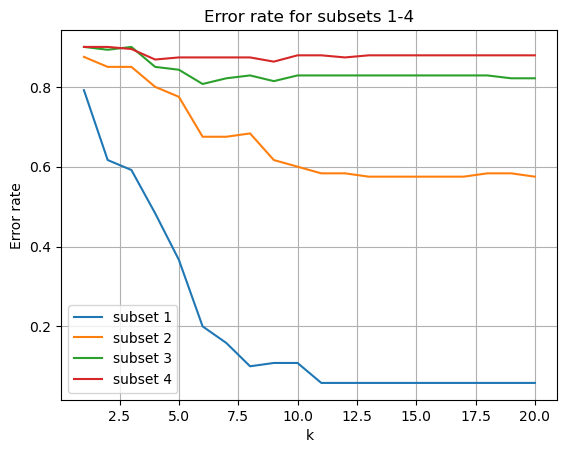

In [6]:
# Plot the error rate
for j in range(4):
    plt.plot(range(1, 21), error[j,:], label=f'subset {str(j+1)}')
plt.title('Error rate for subsets 1-4')
plt.xlabel('k')
plt.ylabel('Error rate')
plt.grid()
plt.legend()
plt.show()

# Part 2

We repeat the above experiment without using the first three principal components and investigate the recognition performance.

In [7]:
error_ = np.zeros((4, 17))

# The number of the used PCs
k = range(4, 21)
for i in k:
    uk, sk, vhk = modified_svd(data_tr[0], k=i)
    for j in range(4):
        # Compute error rate for different subsets
        error_[j, i - 4] = error_rate_knn(data_tr[0], data_te[j], lb_tr[0],
                                          lb_te[j], uk[:,
                                                       3:], sk[3:], vhk[3:, :])


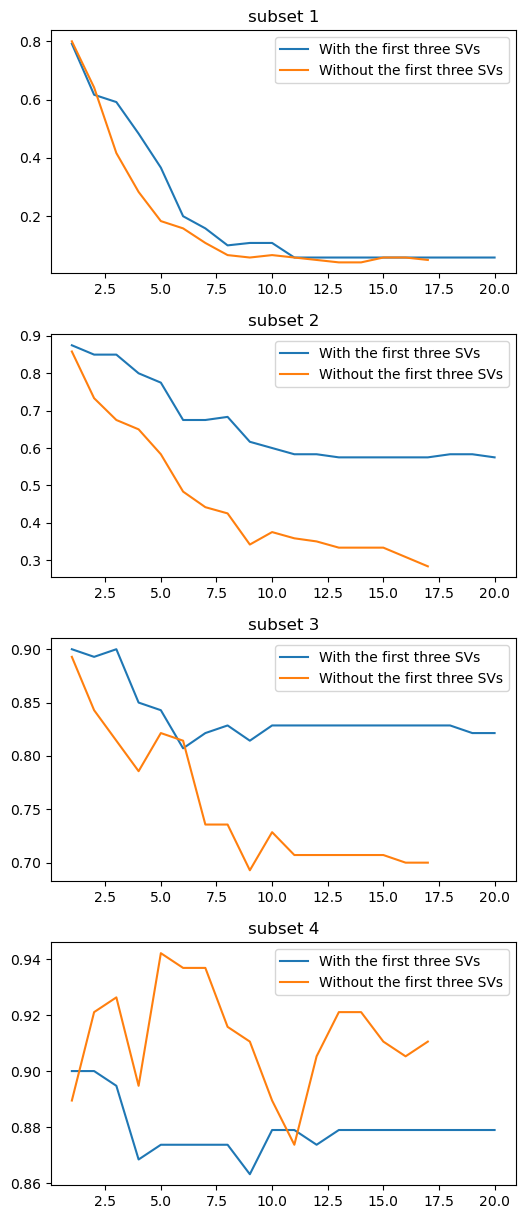

In [8]:
# Show the pictures.
plt.figure(figsize=[6, 15])
plt.subplots_adjust(wspace =0, hspace =0.25)
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(range(1, 21), error[i,:], label=f'With the first three SVs')
    plt.plot(range(1, 18), error_[i,:], label=f'Without the first three SVs')
    plt.title(f'subset {str(i+1)}')
    plt.legend()
plt.show()

From the figures of the 4 subsets we can conclude that PCA cannot determine the classification ability.

In subset 1, it does not matter whether the first three PCs were used or not, both curves can achieve very low error rates, which means that all PCs are as good at separating samples by labels. In subsets 2 and 3, the curve without the first three PCs shows better recognition performance. The reason for that is the remaining PCs are better at separating samples by labels. Subset 4 did the opposite, as the first three PCs are better at separating samples by labels than the rest.